In [1]:
import numpy as np

import random

#Audio player
import IPython.display as ipd

#Data Visualization
import matplotlib.pyplot as plt
import librosa.display

import os

import math
from numpy.fft import fft

C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Methods used for data visualization

In [2]:
#Magnitudes calculation
def fft_extractor(audios, window, window_size, hop_length):
    ffts  = []
    for example in audios :
        fftsLocal = []
        minimum = min(example)
        example = ((np.asarray(example)-minimum)/(max(example)-minimum))*2-1
        n = int((len(example)-window_size)/hop_length)+1
        for i in range (n):
            audio = example[i*hop_length:i*hop_length+window_size]
            samples = len(audio)
            power = 0

            window = window/sum(window)

            np.set_printoptions(precision=4, suppress = True)
            weightedAudio = np.asarray(audio * window)
            for i in range(weightedAudio.size):
                weightedAudio[i] = weightedAudio[i]
            hN = int((samples/2))                                   # size of positive spectrum, it includes sample 0
            hM1 = int(math.floor((window.size+1)/2))                # half analysis window size by rounding
            hM2 = int(math.floor(window.size/2))                    # half analysis window size by floor
            fftbuffer = np.zeros(samples)                           # initialize buffer for FFT
            fftbuffer[:hM1] = weightedAudio[hM2:]                   # zero-phase window in fftbuffer
            fftbuffer[-hM2:] = weightedAudio[:hM2]

            fftAudio = fft(fftbuffer)

            absX = abs(fftAudio[:hN]) # compute ansolute value of positive side
            absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
            mX = 20 * np.log10(absX)
            
            fftsLocal.append(mX[:len(mX)])
        ffts.append(fftsLocal)
    return ffts

In [3]:
#Mel-scale filter bank coefficients calculation
def melFilterBank(signal,sr = 8000):
    audios = [signal]
    
    windowSize = 512 
    hopLength = 448

    window = np.hamming(windowSize)

    extract = fft_extractor(audios, window, windowSize, hopLength) #Magnitude

    pow_frames = ((1.0 / windowSize) * ((np.asarray(extract)) ** 2))# Power Spectrum

    nfilt = 32 #number of filter bank coefficients
    scal = np.empty(nfilt)
    nqyst = int(sr/2)
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + nqyst / 700))
    mel_points = [] #taille nfilt+2
    distance = high_freq_mel/(nfilt+1)
    for i in range(nfilt+2):
        mel_points.append(distance*i)
    mel_points = np.asarray(mel_points)
    #mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))

    binn = np.floor((windowSize + 1) * hz_points / sr)
    
    fbank = np.zeros((nfilt, int(np.floor(windowSize / 2))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(binn[m - 1])   # left
        f_m = int(binn[m])             # center
        f_m_plus = int(binn[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - binn[m - 1]) / (binn[m] - binn[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (binn[m + 1] - k) / (binn[m + 1] - binn[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, 0.000000000000001, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    return np.asarray(filter_banks)[0].T

In [9]:
def displayAudio(audioFile, file, frequency = 8000):
    
# Traitement audio
    signal, fs = librosa.load(audioFile, sr=frequency)
    
    #utilisation d'un seul canal audio
    if(signal.ndim == 2):
        signal = signal[:,1]
    
    duree = signal.size/fs
    
    #tronquer le signal à la longueur voulue
    duree = 8192
    signal = signal[0:duree]
    
    time = np.linspace(0., duree, signal.size)
    
# Affichage signal audio
    plt.plot(time, signal[:])
    plt.title("fichier \'"+file+"\' : signal, spectrogramme, lecteur audio")
    plt.xlabel("Temps [s]")
    plt.ylabel("Amplitude")
    plt.show()
    
# Affichage Mel-scale filter bank coefficients
    fb = melFilterBank(signal,8000)
    fig, ax = plt.subplots()
    fb_dB = librosa.power_to_db(fb, ref=np.max)
    img = librosa.display.specshow(fb_dB, x_axis='time',
                             y_axis='mel', sr=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-scale filter bank coefficients')
# Affichage MFCC
    fig, ax = plt.subplots(nrows=2)
    mfccs = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=14)
    #print(mfccs.shape)
    #print(mfccs[0])
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[0])

    fig.colorbar(img, ax=[ax[0]])

    ax[0].set(title='MFCC')
    
# Affichage spectrogramme
    powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(signal, Fs=fs, mode='magnitude')
    plt.show()
    
    
# Affichage lecteur audio
    ipd.display(ipd.Audio(audioFile))

In [15]:
def displaySamples(sampleNumber = 5):

# US sirens' class dataset visualization
#     rangeInf = 1
#     rangeSup = 200
#     location = "../../datasets/emergencyUS/sounds/" #https://www.kaggle.com/datasets/vishnu0399/emergency-vehicle-siren-sounds
#     for n in random.sample(range(rangeInf, rangeSup), sampleNumber):
#         file = "ambulance/sound_"+str(n)
#         displayAudio(location+file, file)
#     for n in random.sample(range(rangeInf, rangeSup), sampleNumber):
#         file = "firetruck/sound_"+str(n+200)
#         displayAudio(location+file, file)
#     for n in random.sample(range(rangeInf, rangeSup), sampleNumber):
#         file = "traffic/sound_"+str(n+400)
#         displayAudio(location+file, file)

# French sirens' class dataset visualization
    sireneFR_dataset_path = '../../datasets/urgenceFR/sons/' #mettre le chemin du dossier contenant les sons des sirènes françaises
    for path in os.listdir(sireneFR_dataset_path):
        liste = []
        n = 0
        while n != sampleNumber:
            choice = random.choice(os.listdir(sireneFR_dataset_path+path))
            if choice not in liste:
                liste.append(choice)
                displayAudio(sireneFR_dataset_path+path+"/"+choice, choice)
                n = n+1
#         break

# Others' class dataset visualization
    contreExemples_dataset_path = "../../datasets/contreExemples/" #mettre le chemin du dossier contenant les sons des contre exemples
    for path in os.listdir(contreExemples_dataset_path):
        liste = []
        n = 0
        while n != sampleNumber :
            choice = random.choice(os.listdir(contreExemples_dataset_path+path))
            if choice not in liste:
                liste.append(choice)
                displayAudio(contreExemples_dataset_path+path+"/"+choice, path+"/"+choice)
                n = n+1
#         break

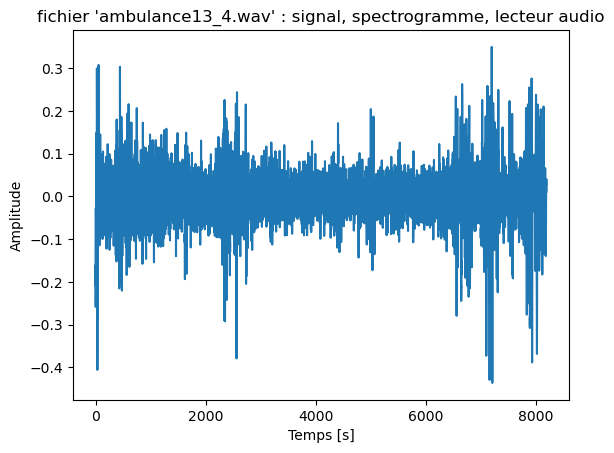

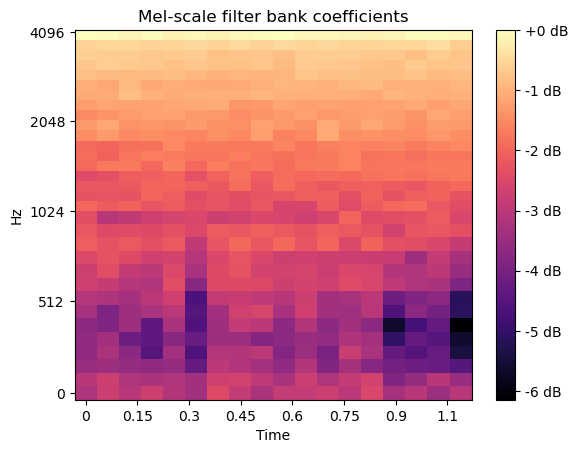

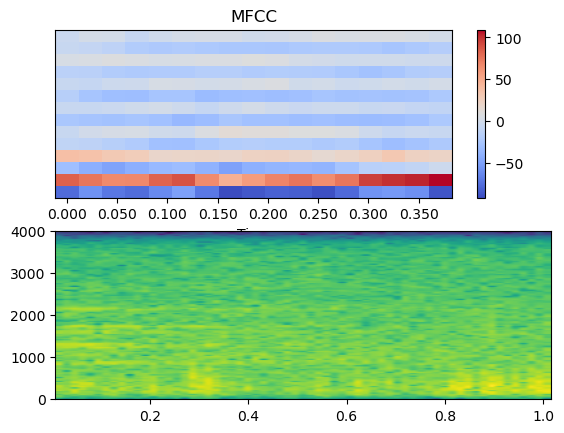

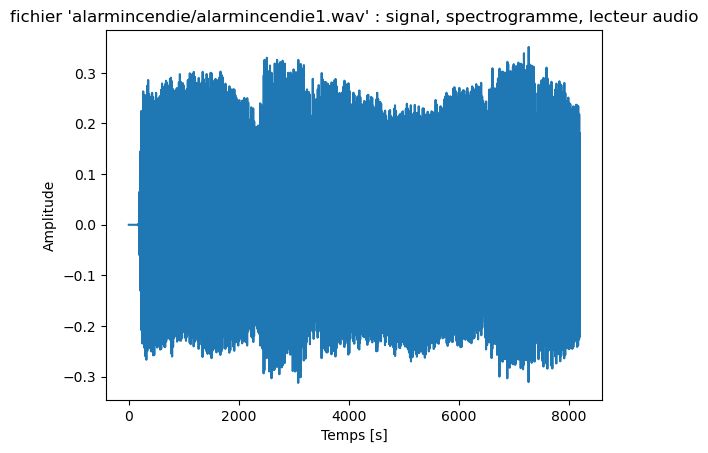

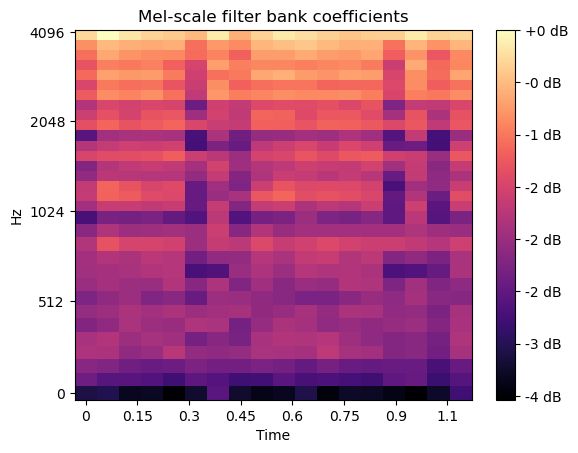

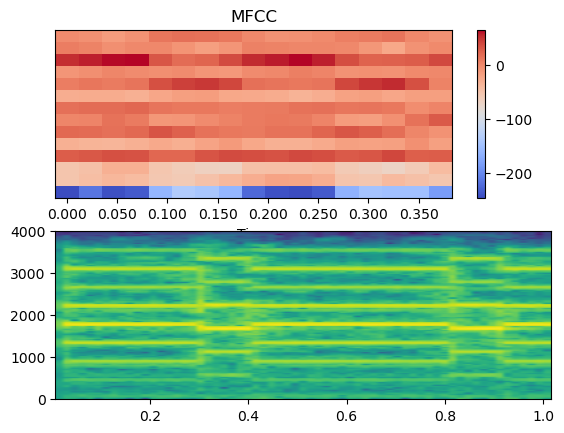

In [16]:
displaySamples(sampleNumber = 1)